In [214]:
import sys
sys.path.append("./cls")

import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="0"

import argparse
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import pyvista as pv
import numpy as np
import torch.optim as optim


from torch.autograd import Variable
from cls.data import ModelNet40
from util import cal_loss
import cls._init_path
from cls.model_mixup import PointNet, DGCNN, Pointnet2_MSG


parser = argparse.ArgumentParser(description='Point Cloud Recognition')
parser.add_argument('--model', type=str, default='dgcnn', metavar='N',
                    choices=['pointnet', 'dgcnn', 'pointnet2_MSG'],
                    help='Model to use, [pointnet, dgcnn]')
parser.add_argument('--data', type=str, default='MN40', metavar='N',
                    choices=['MN40', 'SONN_EASY', 'SONN_HARD'])
parser.add_argument('--batch_size', type=int, default=16, metavar='batch_size',
                    help='Size of batch)')
parser.add_argument('--test_batch_size', type=int, default=16, metavar='batch_size',
                    help='Size of batch)')
parser.add_argument('--epochs', type=int, default=250, metavar='N',
                    help='number of episode to train ')
parser.add_argument('--optim', type=str, default="sgd",
                    choices=['sgd', 'adam'],
                    help='Optimizer, [sgd, adam]')
parser.add_argument('--lr', type=float, default=0.001, metavar='LR',
                    help='learning rate (default: 0.001, 0.1 if using sgd)')
parser.add_argument('--momentum', type=float, default=0.9, metavar='M',
                    help='SGD momentum (default: 0.9)')
parser.add_argument('--scheduler', type=str, default='cos', metavar='N',
                    choices=['cos', 'step'],
                    help='Scheduler to use, [cos, step]')
parser.add_argument('--no_cuda', type=bool, default=False,
                    help='enables CUDA training')
parser.add_argument('--seed', type=int, default=1, metavar='S',
                    help='random seed (default: 1)')
parser.add_argument('--eval', type=bool,  default=False,
                    help='evaluate the model')
parser.add_argument('--num_points', type=int, default=1024,
                    help='num of points to use')
parser.add_argument('--dropout', type=float, default=0.5,
                    help='initial dropout rate')
parser.add_argument('--emb_dims', type=int, default=1024, metavar='N',
                    help='Dimension of embeddings')
parser.add_argument('--k', type=int, default=20, metavar='N',
                    help='Num of nearest neighbors to use')
parser.add_argument('--model_path', type=str, default='', metavar='N',
                    help='Pretrained model path')

parser.add_argument('--aug', type=str, default='default', metavar='N',
                    choices=['default', 'MN40'])
parser.add_argument("--kermix", type=bool, default= True)    
# parser.add_argument("--manimix", type=bool, default=False) 
parser.add_argument("--manimix", type=bool, default=True) 
parser.add_argument("--basemix", type=bool, default=True) 
parser.add_argument('--sigma', type=float, default=0.3) 
parser.add_argument('--beta', type=float, default=5.)  
parser.add_argument('--no_saliency', action='store_true')
parser.add_argument('--smoothing_k', type=int, default=20) 
parser.add_argument('--temperature', type=float, default=2)
parser.add_argument('--temperature2', type=float, default=1)  
parser.add_argument('--sample_ver', type=int, default=3) 
args = parser.parse_args([])


num_class = 40

train_loader = DataLoader(ModelNet40(partition='test', num_points=args.num_points), num_workers=8,
                                batch_size=args.batch_size, shuffle=True, drop_last=False)
device = torch.device("cuda")


In [8]:
import torch
from torch.utils.data import DataLoader
import pyvista as pv
import numpy as np

from cls.data_ij import ModelNet40
from util import cal_loss
from PointMixup.emd_ import emd_module
EMD = emd_module.emdModule()

modelnet_test = ModelNet40(partition='test', num_points=2048)

device = torch.device("cuda")

def get_pc(class_num, dataset=modelnet_test, idx=None, num_points=1024):
    if idx==None:
        class_idx = np.where(dataset.label[:]==class_num)[0]
        idx = np.random.choice(class_idx)
    pc = dataset.data[idx]
    return pc[:num_points], idx

def get_pc_batch(class_1, class_2, batch_size=16, dataset=modelnet_test, idx_list=None, num_points=1024):
    A = []
    B = []
    if idx_list is None:
        A_idx_list = []
        B_idx_list = []
        for i in range(batch_size):
            a, a_idx = get_pc(class_1, dataset=dataset, idx=None, num_points=num_points)
            b, b_idx = get_pc(class_2, dataset=dataset, idx=None, num_points=num_points)
            A.append(a)
            B.append(b)
            A_idx_list.append(a_idx)
            B_idx_list.append(b_idx)
        idx_list = (A_idx_list, B_idx_list)
    else:
        for i, j in zip(*idx_list):
            a, _ = get_pc(class_1, dataset=dataset, idx=i, num_points=num_points)
            b, _ = get_pc(class_2, dataset=dataset, idx=j, num_points=num_points)
            A.append(a)
            B.append(b)
    A = np.stack(A)
    B = np.stack(B)
    return torch.from_numpy(A), torch.from_numpy(B), idx_list

In [9]:
def knn(x, k):
    inner = -2*torch.matmul(x.transpose(2, 1), x)
    xx = torch.sum(x**2, dim=1, keepdim=True)
    pairwise_distance = -xx - inner - xx.transpose(2, 1)
 
    idx = pairwise_distance.topk(k=k, dim=-1)[1]   # (batch_size, num_points, k)
    return idx
def saliency_smoothing(xyz, saliency, k=20, temperature=2):
    B, N, _ = xyz.shape
    idx = knn(xyz.permute(0,2,1), k)
    idx_base = torch.arange(0, B, device=xyz.device).view(-1, 1, 1)*1024
    idx = idx + idx_base
    idx = idx.view(-1)
    saliency = saliency.view(-1)[idx].reshape(B, N, k) #(b, 1024, k)
    saliency = saliency.mean(-1)**temperature #(b, 1024)

    return saliency
def normalize(weight, axis=None):
    if axis is None:
        weight = (weight-np.min(weight)) / (np.max(weight)-np.min(weight))
    else:
        m = np.expand(np.min(weight, axis), axis)
        M = np.expand(np.max(weight, axis), axis)
        weight = (weight-m) / (M-m)
    return weight

## Prepare viz

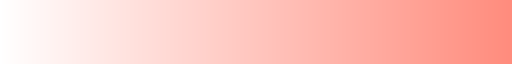

In [616]:
import pyvista as pv
import numpy as np

def get_shadow(plotter, pos, point_size, scale=3, origin=None, opacitiy=0.1, color= "#dddddd"):
    #pos (n,3)
    pos  =pos.repeat(scale, 0) 
    pos +=  np.random.rand(pos.shape[0],pos.shape[1])/20

    point_cloud = pv.PolyData(pos)

    if origin is None:
        origin = [0,0,pos[:,2].min() - 0.05]
    point_cloud = point_cloud.project_points_to_plane(origin=origin, normal=[0,0,-1])
    
    plotter.add_points(point_cloud, point_size=point_size, render_points_as_spheres=True,\
                        opacity=opacitiy, color = color, lighting=False) 


pv.start_xvfb()
from matplotlib.colors import ListedColormap

s_color = np.array([255, 255, 255, 255])/255
e_color = np.array([0, 128, 0, 255])/255
lin = np.linspace(0,1,256)
np.expand_dims((e_color - s_color),1)*np.expand_dims(lin,0)
color_map = np.expand_dims(s_color,1) + np.expand_dims((e_color - s_color),1)*np.expand_dims(lin,0)
distance_cmap = ListedColormap(color_map.transpose((1,0)))

s_color = np.array([255, 237, 188, 255])/255
e_color = np.array([255, 140, 125, 255])/255
lin = np.linspace(0,1,256)
np.expand_dims((e_color - s_color),1)*np.expand_dims(lin,0)
color_map = np.expand_dims(s_color,1) + np.expand_dims((e_color - s_color),1)*np.expand_dims(lin,0)
a_cmap = ListedColormap(color_map.transpose((1,0)))

s_color = np.array([255, 255, 255, 255])/255
e_color = np.array([186, 173, 255, 255])/255
# e_color = np.array([145, 125, 255, 255])/255
# e_color = np.array([158, 118, 166, 255])/255
lin = np.linspace(0,1,256)
np.expand_dims((e_color - s_color),1)*np.expand_dims(lin,0)
color_map = np.expand_dims(s_color,1) + np.expand_dims((e_color - s_color),1)*np.expand_dims(lin,0)
kernel_cmap = ListedColormap(color_map.transpose((1,0)))

s_color = np.array([255, 255, 255, 255])/255
e_color = np.array([38, 148, 171, 255])/255
lin = np.linspace(0,1,256)
np.expand_dims((e_color - s_color),1)*np.expand_dims(lin,0)
color_map = np.expand_dims(s_color,1) + np.expand_dims((e_color - s_color),1)*np.expand_dims(lin,0)
aug_cmap = ListedColormap(color_map.transpose((1,0)))


s_color = np.array([255, 255, 255, 255])/255
e_color = np.array([255, 140, 125, 255])/255
lin = np.linspace(0,1,256)
np.expand_dims((e_color - s_color),1)*np.expand_dims(lin,0)

color_map = np.expand_dims(s_color,1) + np.expand_dims((e_color - s_color),1)*np.expand_dims(lin,0)
cmap = ListedColormap(color_map.transpose((1,0)))
cmap

In [11]:
def visualize_batch(A, B, aug, cmap, point_size, camera_position, A_weight, B_weight, aug_weight, index=None):
    if isinstance(A, torch.Tensor):
        A = A.cpu().numpy()
        B = B.cpu().numpy()
        aug = aug.cpu().numpy()
    
    if index==None:
        index = range(len(aug))

    for i in index:
        plotter = pv.Plotter(notebook=True, shape=(1,3))
            
        plotter.subplot(0, 0)
        plotter.background_color = "W"
        point_cloud = pv.PolyData(A[i][:,[0,2,1]])
        # point_cloud['y'] = np.zeros(len(A[i]))
        point_cloud['y'] = A_weight[i]
        plotter.add_points(point_cloud, point_size=point_size, render_points_as_spheres=True, cmap=cmap)
        plotter.camera_position = camera_position
        get_shadow(plotter, A[i][:,[0,2,1]], point_size)
        
        plotter.subplot(0, 1)
        plotter.background_color = "W"
        point_cloud = pv.PolyData(aug[i][:,[0,2,1]])
        point_cloud['y'] = aug_weight[i]
        plotter.add_points(point_cloud, point_size=point_size, render_points_as_spheres=True, cmap=cmap)
        plotter.camera_position = camera_position
        get_shadow(plotter, aug[i][:,[0,2,1]], point_size)
        
        plotter.subplot(0, 2)
        plotter.background_color = "W"
        point_cloud = pv.PolyData(B[i][:,[0,2,1]])
        # point_cloud['y'] = np.ones(len(B[i]))
        point_cloud['y'] = B_weight[i]
        plotter.add_points(point_cloud, point_size=point_size, render_points_as_spheres=True, cmap=cmap)
        plotter.camera_position = camera_position
        get_shadow(plotter, B[i][:,[0,2,1]], point_size)

#         light = pv.Light(intensity=0.15, shadow_attenuation = 0)
        light = pv.Light(intensity=0.20, shadow_attenuation = 0)
        light.set_direction_angle(30,0)
        plotter.add_light(light)
#         light = pv.Light(intensity=0.12, shadow_attenuation = 0)
        light = pv.Light(intensity=0.16, shadow_attenuation = 0)
        light.set_direction_angle(30,180)
        plotter.add_light(light)

        plotter.show()
    return plotter
    
def save_pdf(A, B, aug, cmap, point_size, camera_position, A_weight, B_weight, aug_weight, filename):
    if isinstance(A, torch.Tensor):
        A = A.cpu().numpy()
        B = B.cpu().numpy()
        aug = aug.cpu().numpy()

    plotter = pv.Plotter(notebook=True, shape=(1,3))

    plotter.subplot(0, 0)
    plotter.background_color = "W"
    point_cloud = pv.PolyData(A[:,[0,2,1]])
    # point_cloud['y'] = np.zeros(len(A[i]))
    point_cloud['y'] = A_weight
    plotter.add_points(point_cloud, point_size=point_size, render_points_as_spheres=True, cmap=cmap)
    plotter.camera_position = camera_position
    get_shadow(plotter, A[:,[0,2,1]], point_size)

    plotter.subplot(0, 1)
    plotter.background_color = "W"
    point_cloud = pv.PolyData(aug[:,[0,2,1]])
    point_cloud['y'] = aug_weight
    plotter.add_points(point_cloud, point_size=point_size, render_points_as_spheres=True, cmap=cmap)
    plotter.camera_position = camera_position
    get_shadow(plotter, aug[:,[0,2,1]], point_size)

    plotter.subplot(0, 2)
    plotter.background_color = "W"
    point_cloud = pv.PolyData(B[:,[0,2,1]])
    # point_cloud['y'] = np.ones(len(B[i]))
    point_cloud['y'] = B_weight
    plotter.add_points(point_cloud, point_size=point_size, render_points_as_spheres=True, cmap=cmap)
    plotter.camera_position = camera_position
    get_shadow(plotter, B[:,[0,2,1]], point_size)

    light = pv.Light(intensity=0.15, shadow_attenuation = 0)
    light.set_direction_angle(30,0)
    plotter.add_light(light)
    light = pv.Light(intensity=0.12, shadow_attenuation = 0)
    light.set_direction_angle(30,180)
    plotter.add_light(light)

    plotter.save_graphic(filename)


In [12]:
camera_pos = [1,-1,1]#,[0,0,1]]
point_size = 9

## Aug Codes

In [140]:
def ours(xyz, perm, alpha=None, anchor=None, x=None, saliency=None, num_points=1024, sigma=0.1, beta=None, saliency_ver=0):
    """
    Args:
        xyz (B,N,3): 
        label (B): 
        x (B,D,N): Defaults to None.
        saliency (B,N): Defaults to None.
    """        

    batch_size = xyz.size(0)
    _, ass = EMD(xyz, perm, 0.005, 10000) # mapping
    ass = ass.long()
    perm_new = torch.zeros_like(perm).to(perm.device)

    for i in range(batch_size):
        perm_new[i] = perm[i][ass[i]]

    if anchor is not None:
        # anchor_ori, anchor_perm = xyz[torch.arange(len(xyz)),anchor[0],:], perm[torch.arange(len(perm)),anchor[1], :]
        # print(anchor_ori.shape)
        anchor_ori, anchor_perm = torch.tensor(anchor[0]).cuda(), torch.tensor(anchor[1]).cuda()
        
    #random_sampling
    elif saliency is None:
        anc_idx = torch.randperm(num_points)[:2]
        anchor_ori, anchor_perm = xyz[:,anc_idx[0],:], perm_new[:,anc_idx[1], :]
    #weighted sampling
    elif saliency_ver == 1:
        anc_idx = torch.multinomial(saliency, 2, replacement=True)
        anchor_ori = xyz[torch.arange(batch_size),anc_idx[:,0]]
        anchor_perm = xyz[torch.arange(batch_size),anc_idx[:,1]][idxs]
    #max
    elif saliency_ver == 2:
        anc_idx = saliency.max(1)[1]
        anchor_ori = xyz[torch.arange(batch_size),anc_idx]
        anchor_perm = anchor_ori[idxs]

    if beta is not None:
        alpha = beta.sample((batch_size,)).to([perm.device])
    elif alpha is not None:
        alpha = alpha
    else:
        alpha = 0.5
        
    if isinstance(sigma, tuple):
        sub_ori = xyz - anchor_ori[:,None,:]
        sub_ori = ((sub_ori) ** 2).sum(2).sqrt()
        weight_ori = torch.exp(-0.5 * (sub_ori ** 2) / (sigma[0]** 2))  #(M,N)
        weight_ori = weight_ori * alpha

        sub_perm = perm_new - anchor_perm[:,None,:]
        sub_perm = ((sub_perm) ** 2).sum(2).sqrt()   
        weight_perm = torch.exp(-0.5 * (sub_perm ** 2) / (sigma[1] ** 2))  #(M,N)
        weight_perm = weight_perm * (1-alpha)
    else:
        sub_ori = xyz - anchor_ori[:,None,:]
        sub_ori = ((sub_ori) ** 2).sum(2).sqrt()
        weight_ori = torch.exp(-0.5 * (sub_ori ** 2) / (sigma ** 2))  #(M,N)
        weight_ori = weight_ori * alpha

        sub_perm = perm_new - anchor_perm[:,None,:]
        sub_perm = ((sub_perm) ** 2).sum(2).sqrt()   
        weight_perm = torch.exp(-0.5 * (sub_perm ** 2) / (sigma ** 2))  #(M,N)
        weight_perm = weight_perm * (1-alpha)

    weight = (torch.cat([weight_ori[...,None],weight_perm[...,None]],-1)) + 1e-16
    weight = weight/weight.sum(-1)[...,None]

    #mixup sampe
    if x is None:
        x = xyz
        perm_x_new = perm_new
    else:
        x = x.permute(0,2,1)
        perm_x = x[idxs]
        perm_x_new = torch.zeros_like(perm_x).cuda()
        for i in range(batch_size):
            perm_x_new[i] = perm_x[i][ass[i]]

    x = weight[:,:,0:1] * x + weight[:,:,1:] * perm_x_new
#     x = x.permute(0,2,1)


    return x, {"mix" : x, "perm" : perm_new, "weight":weight, "weight_ori":weight_ori, "weight_perm":weight_perm, "perm_x_new" : perm_x_new}

1609 315, 155, 358  ss 1294

plane 1676
guitar 1609

In [134]:
plane = torch.load("./injae/plane.pt")
car = torch.load("./injae/car.pt")
plane, idx = get_pc(0, dataset=modelnet_test, idx=1676, num_points=1024)
print(idx)
guitar, idx = get_pc(17, dataset=modelnet_test, idx=1609, num_points=1024)
batch_size = 1

# A = plane[:1024].unsqueeze(0)
# B = car[:1024].unsqueeze(0)
A = torch.from_numpy(plane[:1024]).to(device).unsqueeze(0)
B = torch.from_numpy(guitar[:1024]).to(device).unsqueeze(0)
# label = torch.tensor([0,7])
label = torch.tensor([0,17])
data = torch.concat([A,B])
data, label = data.to(device), label.to(device).squeeze()

1676


In [135]:
rotate_matrix = torch.tensor([[0, 0, -1],
                            [ 0,  1., 0],
                            [ 1,  0, 0]]).to(device)
B = torch.inner(B, rotate_matrix)
B = torch.inner(B, rotate_matrix)
B = torch.inner(B, rotate_matrix)

In [136]:
# A_idx = torch.argmax(A[:,:,2], 1)
A_idx = 6
A_idx = torch.argsort(A[:,:,2], 1)[0,-8].item()


# distance_weight = np.abs(torch.sum(B[0]-A[0,A_idx], 1).cpu())
distance_weight = np.abs(torch.sum((B[0]-A[0,A_idx])**2, 1).cpu())
distance_weight = normalize(distance_weight.numpy())

B_idx = np.argmax(normalize(distance_weight))


In [480]:
anchor =[]
# anchor.append(A_idx)
# anchor.append(B_idx)
# A_anchor = pv.PolyData((A+trl).cpu().numpy()[0,A_idx:A_idx+1][:,[0,2,1]])
# B_anchor = pv.PolyData(B.cpu().numpy()[0,B_idx:B_idx+1][:,[0,2,1]])

temp_A = A


A_anchor = temp_A.cpu().numpy()[0,A_idx:A_idx+1]#[:,[0,2,1]]
B_anchor = B.cpu().numpy()[0,B_idx:B_idx+1]#[:,[0,2,1]]

# A_anchor = np.array([[0,0.1,3]])
B_anchor = np.array([[0,0,1]])

anchor.append(A_anchor)
anchor.append(B_anchor)

trl = torch.tensor([[[0,0,1]]]).cuda()
output = ours(A+trl, B, alpha=0.7, anchor=anchor, sigma=0.4) # sigma=0.4)

aug = output[0]
aug_weight = output[1]['weight'][:,:,1]



In [604]:
lines.reshape(-1,3)[high_weight_idxs].reshape(-1).shape

(207,)

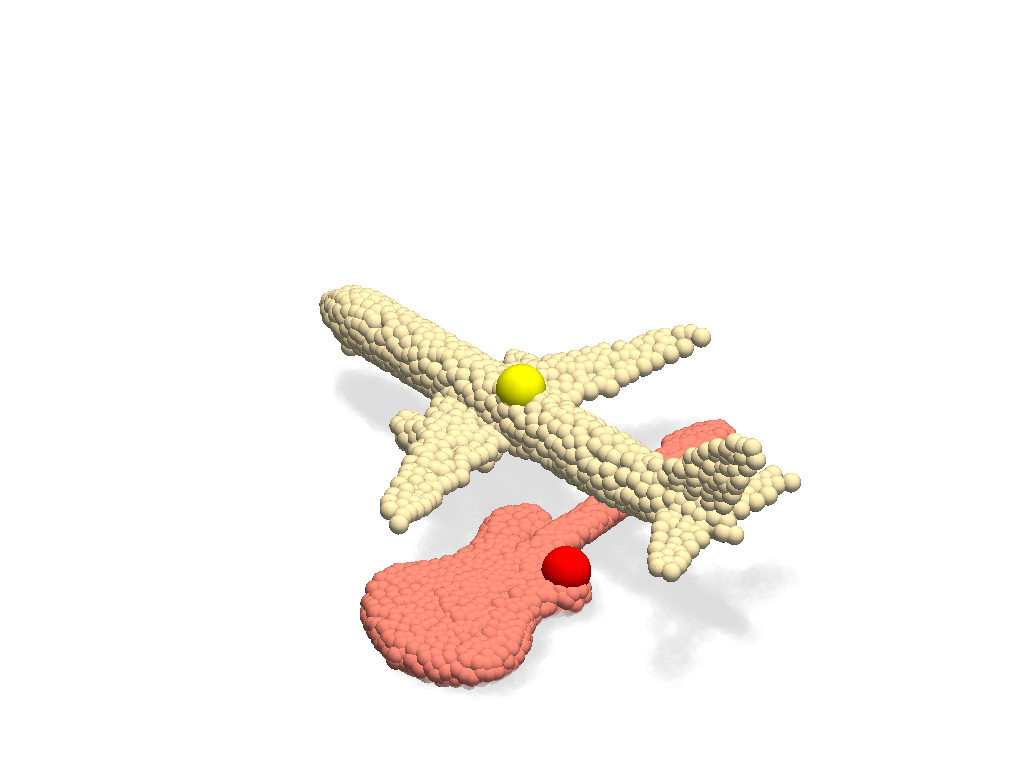

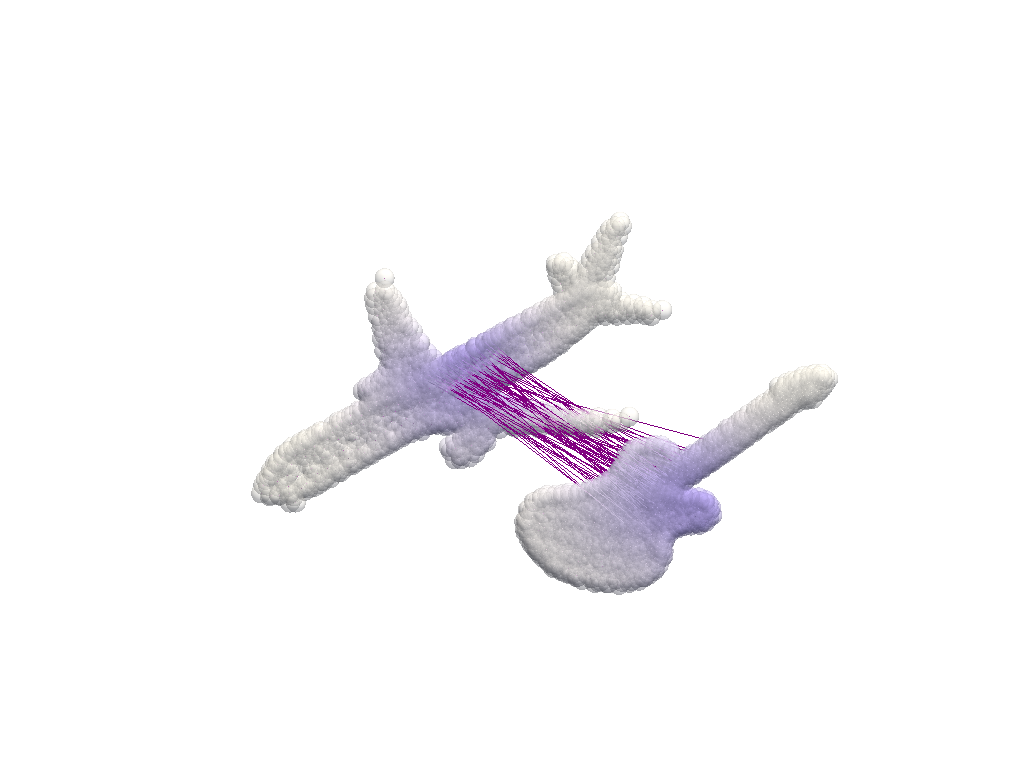

In [613]:
anchor =[]
# anchor.append(A_idx)
# anchor.append(B_idx)
# A_anchor = pv.PolyData((A+trl).cpu().numpy()[0,A_idx:A_idx+1][:,[0,2,1]])
# B_anchor = pv.PolyData(B.cpu().numpy()[0,B_idx:B_idx+1][:,[0,2,1]])

# #origin
# temp_A = A.clone()
# A_anchor = np.array([[0,0.1,0]])
# B_anchor = np.array([[0.15,0.05,0.05]])

# #rotation
temp_A = A.clone()
temp_A[:,:,[0,2]] = temp_A[:,:,[2,0]]

t = [-0.3,0.3,0.3]

temp_A = temp_A + torch.tensor([[t]]).cuda()
A_anchor = np.array([[-0.3,0.4,0.3]])
B_anchor = np.array([[0.15,0.05,0.05]])

#trl
# temp_A = A.clone()
# temp_A = temp_A + torch.tensor([[[-1,0,0]]]).cuda()
# A_anchor = np.array([[-1,0.1,0]])
# B_anchor = np.array([[0.15,0.05,0.05]])

#trl + rotation
# temp_A = A.clone()
# temp_A[:,:,[0,2]] = -temp_A[:,:,[2,0]] 
# temp_A =  temp_A + torch.tensor([[[1.5,0,0]]]).cuda()
# A_anchor = np.array([[1.5,0.1,0]])
# B_anchor = np.array([[0.15,0.05,0.05]])

anchor.append(A_anchor)
anchor.append(B_anchor)

output = ours(temp_A, B, anchor=anchor, sigma=0.4) # sigma=0.4)

aug = output[0]
aug_weight = output[1]['weight'][:,:,1]

lines=np.stack([np.array([2]).repeat(1024), np.arange(1024), np.arange(1024,2048)]).transpose(1,0).reshape(-1)
total = torch.cat([A + torch.tensor([[[-1,0,0]]]).cuda(),output[1]["perm_x_new"]],1)

point_size = 20

for i in range(1):
    plotter = pv.Plotter(notebook=True, shape=(1,1))

    plotter.background_color = "W"
    point_cloud = pv.PolyData(temp_A.cpu().numpy()[i][:,[0,2,1]])
    point_cloud['y'] = np.zeros(len(A[i]))
    plotter.add_points(point_cloud, point_size=point_size, render_points_as_spheres=True, color = a_cmap.colors[0][:3])
    plotter.camera_position = camera_pos
    get_shadow(plotter, temp_A.cpu().numpy()[i][:,[0,2,1]], point_size)
    plotter.add_points(A_anchor[:,[0,2,1]], point_size=50, render_points_as_spheres=True, color="Y")
    

    point_cloud = pv.PolyData(B.cpu().numpy()[i][:,[0,2,1]])
    point_cloud['y'] = np.zeros(len(A[i]))
    plotter.add_points(point_cloud, point_size=point_size, render_points_as_spheres=True, color=a_cmap.colors[-1][:3])# ,color=np.array([200,150,35])/255)
    # plotter.camera_position = camera_pos
    get_shadow(plotter, B.cpu().numpy()[i][:,[0,2,1]], point_size)
    plotter.add_points(B_anchor[:,[0,2,1]], point_size=50, render_points_as_spheres=True, color="R")

    light = pv.Light(intensity=0.20, shadow_attenuation = 0)
    light.set_direction_angle(30,0)
    plotter.add_light(light)
    light = pv.Light(intensity=0.16, shadow_attenuation = 0)
    light.set_direction_angle(30,180)
    plotter.add_light(light)
    # plotter.remove_scalar_bar()
    plotter.screenshot("./injae/tmp.png")
    plotter.show(jupyter_backend="static")
    
for i in range(1):
    plotter = pv.Plotter(notebook=True, shape=(1,1))

    plotter.subplot(0, 0)
    plotter.background_color = "W"
    point_cloud = pv.PolyData(total.cpu().numpy()[i][:,[0,2,1]])
    
    w1 = normalize(output[1]['weight_ori'].cpu().numpy())[i]
    w2 = normalize(output[1]['weight_perm'].cpu().numpy())[i]
    
    high_weight_idxs = (w1>0.9)
    high_weight_idxs = np.arange(1024)[high_weight_idxs]
    
    point_cloud.lines=lines.reshape(-1,3)[high_weight_idxs].reshape(-1)
    point_cloud['y'] = np.zeros(len(total[0]))
    plotter.add_mesh(point_cloud, point_size=0.001, render_points_as_spheres=False, color="purple")
    
    
    point_cloud = pv.PolyData(total.cpu().numpy()[i][:,[0,2,1]])
    point_cloud['y'] = np.concatenate([w1,w2])**2
    plotter.add_points(point_cloud, point_size=point_size, render_points_as_spheres=True, cmap= kernel_cmap, opacity=0.5)
    plotter.camera_position = camera_pos
    # get_shadow(plotter, A.cpu().numpy()[i][:,[0,2,1]], point_size)
    
    
    plotter.remove_scalar_bar()
    light = pv.Light(intensity=0.20, shadow_attenuation = 0)
    light.set_direction_angle(30,0)
    plotter.add_light(light)
    light = pv.Light(intensity=0.16, shadow_attenuation = 0)
    light.set_direction_angle(30,180)
    plotter.add_light(light)
    plotter.screenshot("./injae/tmp.png")
    plotter.show(jupyter_backend="static")

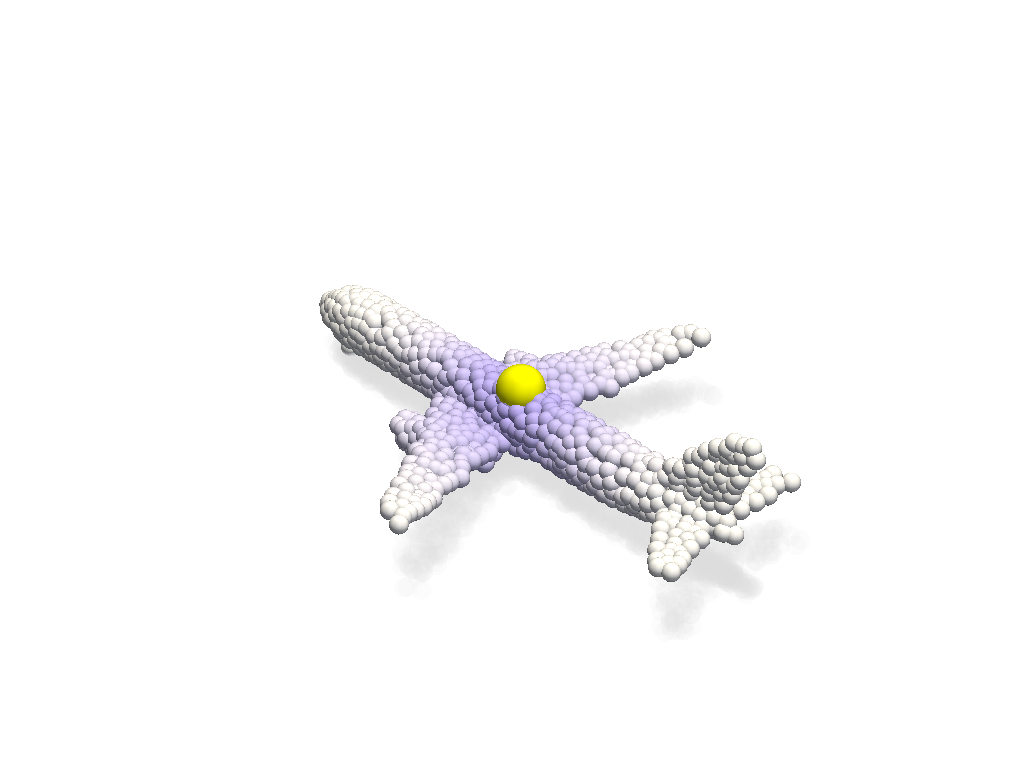

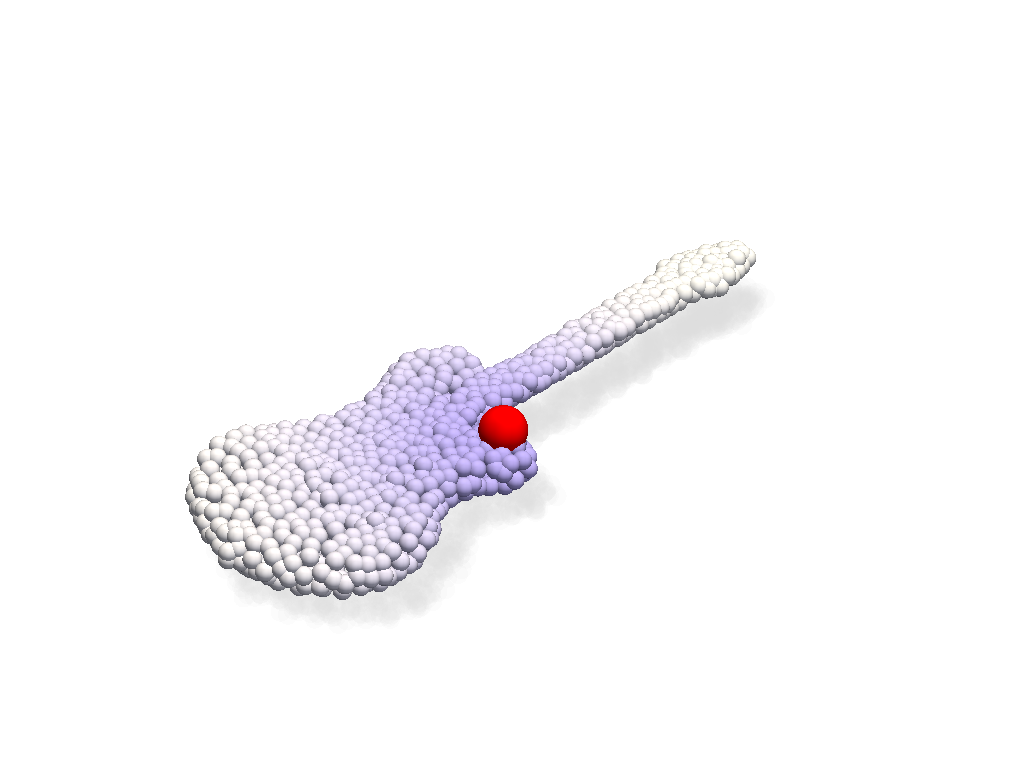

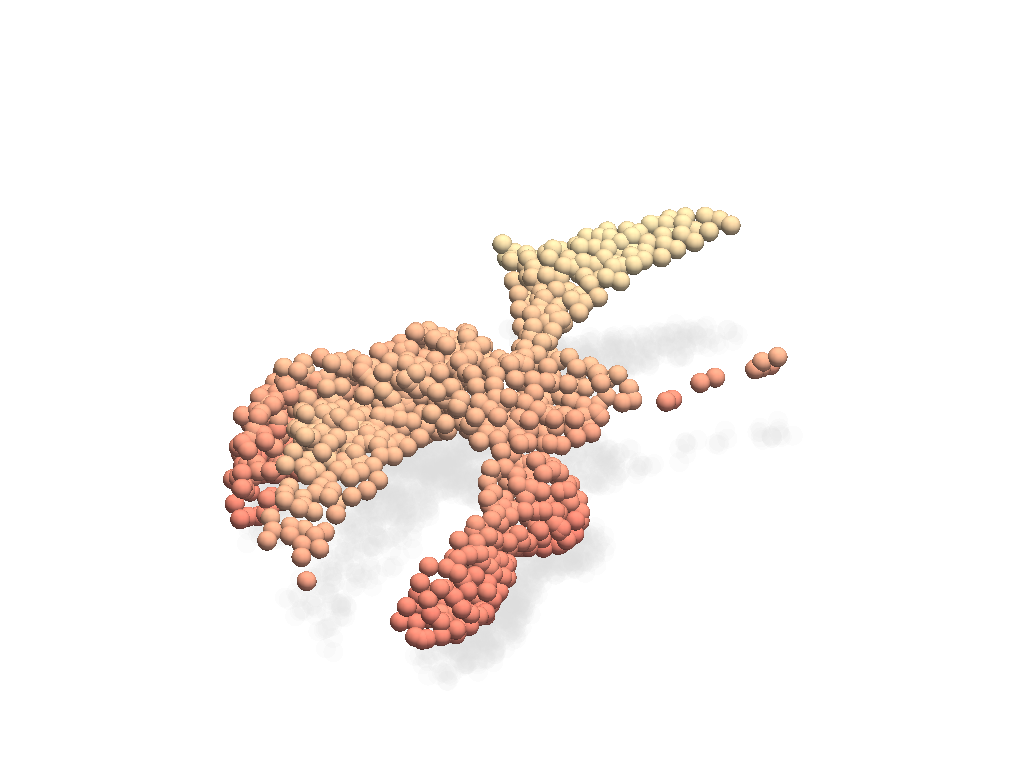

In [617]:
for i in range(1):
    plotter = pv.Plotter(notebook=True, shape=(1,1))
    plotter.background_color = "W"
    point_cloud = pv.PolyData(temp_A.cpu().numpy()[i][:,[0,2,1]])
    # point_cloud['y'] = np.zeros(len(A[i]))
    point_cloud['y'] = normalize(output[1]['weight_ori'].cpu().numpy())[i]**2
    # point_cloud['y'] = A_weight[i]
    plotter.add_points(point_cloud, point_size=20, render_points_as_spheres=True, cmap=kernel_cmap)
    plotter.camera_position = camera_pos
    get_shadow(plotter, temp_A.cpu().numpy()[i][:,[0,2,1]], point_size)
    plotter.add_points(A_anchor[:,[0,2,1]], point_size=50, render_points_as_spheres=True, color="Y")
    
    light = pv.Light(intensity=0.20, shadow_attenuation = 0)
    light.set_direction_angle(30,0)
    plotter.add_light(light)
    light = pv.Light(intensity=0.16, shadow_attenuation = 0)
    light.set_direction_angle(30,180)
    plotter.remove_scalar_bar()
    plotter.add_light(light)
    plotter.show(jupyter_backend="static")
# 

    plotter = pv.Plotter(notebook=True, shape=(1,1))
    plotter.background_color = "W"
    point_cloud = pv.PolyData(output[1]['perm'].cpu().numpy()[i][:,[0,2,1]])
    # point_cloud['y'] = np.zeros(len(B[i]))
    # point_cloud['y'] = B_weight[i]
    point_cloud['y'] = normalize(output[1]['weight_perm'].cpu().numpy())[i]**2
    # point_cloud['y'] = normalize(distance_weight * B_weight[i].numpy())
    plotter.add_points(point_cloud, point_size=20, render_points_as_spheres=True, cmap=kernel_cmap)
    # plotter.add_points(point_cloud, point_size=point_size, render_points_as_spheres=True, cmap=cmap)
    plotter.camera_position = camera_pos
    get_shadow(plotter, B.cpu().numpy()[i][:,[0,2,1]], point_size)
    plotter.add_points(B_anchor[:,[0,2,1]], point_size=50, render_points_as_spheres=True, color="R")

    # light = pv.Light(intensity=0.15, shadow_attenuation = 0)
    light = pv.Light(intensity=0.20, shadow_attenuation = 0)
    light.set_direction_angle(30,0)
    plotter.add_light(light)
    # light = pv.Light(intensity=0.12, shadow_attenuation = 0)
    light = pv.Light(intensity=0.16, shadow_attenuation = 0)
    light.set_direction_angle(30,180)
    plotter.remove_scalar_bar()
    plotter.add_light(light)
    plotter.show(jupyter_backend="static")
    
    plotter = pv.Plotter(notebook=True, shape=(1,1))
    plotter.background_color = "W"
    point_cloud = pv.PolyData(aug.cpu().numpy()[i][:,[0,2,1]])
    point_cloud['y'] = aug_weight.cpu()[i]
    # plotter.add_points(point_cloud, point_size=point_size, render_points_as_spheres=True, color=aug_cmap(1.)[:3])
    plotter.add_points(point_cloud, point_size=20, render_points_as_spheres=True, cmap=a_cmap)
    plotter.camera_position = camera_pos
    # get_shadow(plotter, aug[i][:,[0,2,1]], point_size, weight=aug_weight.cpu().numpy()[i], scale=1)
    get_shadow(plotter, aug.cpu().numpy()[i][:,[0,2,1]], point_size)
    
    light = pv.Light(intensity=0.20, shadow_attenuation = 0)
    light.set_direction_angle(30,0)
    plotter.add_light(light)
    # light = pv.Light(intensity=0.12, shadow_attenuation = 0)
    light = pv.Light(intensity=0.16, shadow_attenuation = 0)
    light.set_direction_angle(30,180)
    plotter.remove_scalar_bar()
    plotter.add_light(light)
    plotter.show(jupyter_backend="static")
